## A * 

- minimizar o custo de uma busca
- utiliza o custo até o objetivo h(n) e o custo de cada nó g(n)
- custo total a ser minimizado -> f(n) = g(n) + h(n)

### Modelando problema de roteamento

<img src="images/srs_campinas.png" width="800" align="center">

In [1]:
class Graph:

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()


    def make_undirected(self):
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.graph_dict.setdefault(b, {})[a] = dist

    def connect(self, A, B, distance=1):
        self.graph_dict.setdefault(A, {})[B] = distance
        if not self.directed:
            self.graph_dict.setdefault(B, {})[A] = distance

    def get(self, a, b=None):
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)


class Node:
    def __init__(self, name:str, parent:str):
        self.name = name
        self.parent = parent
        self.g = 0 # Distance to start node
        self.h = 0 # Distance to goal node
        self.f = 0 # Total cost    

    def __eq__(self, other):
        return self.name == other.name
    
    def __lt__(self, other):
         return self.f < other.f
    
    def __repr__(self):
        return ('({0},{1})'.format(self.name, self.f))

    def __hash__(self):
        return hash(self.name)

#### Populando grafo

In [2]:
graph = Graph()

graph.connect('SRS', 'Pouso_Alegre', 28.9)
graph.connect('Pouso_Alegre', 'Cambui', 49.1)
graph.connect('Pouso_Alegre', 'Congonhal', 24.3)
graph.connect('Pouso_Alegre', 'Borda', 28.8)
graph.connect('Cambui', 'Camanducaia', 24.7)
graph.connect('Camanducaia', 'Braganca', 60.4)
graph.connect('Braganca', 'Atibaia', 25.2)
graph.connect('Braganca', 'Itapira', 82.4)
graph.connect('Atibaia', 'Campinas', 65.6)
graph.connect('Itapira', 'Campinas', 70.7)
graph.connect('Borda', 'Jacutinga', 57.6)
graph.connect('Jacutinga', 'Itapira', 33.2)
graph.connect('Congonhal', 'Ipuiuna', 24.6)
graph.connect('Ipuiuna', 'Andradas', 67.5)
graph.connect('Andradas', 'ESPinhal', 28.4)
graph.connect('ESPinhal', 'MogiGuacu', 35.7)
graph.connect('MogiGuacu', 'MogiMirim', 25)
graph.connect('MogiMirim', 'Campinas', 60.1)

graph.make_undirected()

heuristics = {}
heuristics['SRS'] = 165
heuristics['Pouso_Alegre'] = 137
heuristics['Cambui'] = 108
heuristics['Camanducaia'] = 97
heuristics['Braganca'] = 54
heuristics['Atibaia'] = 57
heuristics['Campinas'] = 0
heuristics['Borda'] = 117
heuristics['Jacutinga'] = 84
heuristics['Itapira'] = 58
heuristics['Congonhal'] = 135
heuristics['Ipuiuna'] = 139
heuristics['Andradas'] = 106
heuristics['ESPinhal'] = 86
heuristics['MogiGuacu'] = 62
heuristics['MogiMirim'] = 54

### Implementando busca

In [5]:
import heapq
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [11]:
# Função para desenhar o grafo
def draw_graph(grafo, path=None):
    """
    Desenha o grafo usando a biblioteca networkx e destaca o caminho encontrado
    Args:
        - grafo: Objeto Graph contendo os nós e arestas
        - path: Lista de nós que formam o caminho encontrado (opcional)
    """
    G = nx.Graph()
    
    # Adicionar nós e arestas ao grafo
    for node in grafo.graph_dict:
        for neighbor, distance in grafo.graph_dict[node].items():
            G.add_edge(node, neighbor, weight=distance)

    # Posição dos nós no gráfico
    pos = nx.spring_layout(G)

    # Desenhar o grafo com pesos nas arestas
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    # Se o caminho for fornecido, destacá-lo em vermelho
    if path:
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)

    plt.show()

# Função para obter o caminho (já existente no seu código)
def get_path(atual, inicial):
    path = []
    while atual != inicial:
        path.append(atual.name)
        atual = atual.parent
    path.append(inicial.name)
    return path[::-1]

# Seu algoritmo A* (com algumas modificações para usar o draw_graph)
def a_star(grafo, heuristicas, inicio, fim):
    """
    Algoritmo A* para encontrar o caminho ótimo de 'inicio' a 'fim'
    Args:
        - grafo: grafo contendo os estados da busca
        - heuristicas: heurística de cada estado
        - inicio: estado inicial
        - fim: estado final
    Return:
        - Melhor caminho entre estados inicial e final, se a solução foi encontrada, quantidade de estados visitados
    """
    
    # Criando nó inicial e nó objetivo (não possuem pai)
    start_node = Node(inicio, None)
    goal_node = Node(fim, None)
    
    # Inicializando atributos g(0) = 0, f(0) = 0 + h(0)
    start_node.g = 0
    start_node.h = heuristicas[inicio]
    start_node.f = start_node.g + start_node.h

    state_id = 0

    # Fila de prioridades
    fila = []
    heapq.heappush(fila, (start_node.f, state_id, start_node))

    # Nós criados e visitados
    created_nodes = []
    visited_nodes = []
    created_nodes.append(start_node)
    
    solucao_encontrada = False
    path = None

    while len(fila) != 0:
        atual = heapq.heappop(fila)[2]
        visited_nodes.append(atual)

        if atual == goal_node:
            path = get_path(atual, start_node)
            solucao_encontrada = True
            break

        # Percorrendo todos os vizinhos do nó atual
        for nome_viz, dist_viz in grafo.get(atual.name).items():
            vizinho = Node(nome_viz, atual)

            g_pai_vizinho = atual.g + dist_viz
            g_vizinho = vizinho.g if vizinho in created_nodes else float('inf')

            if g_pai_vizinho < g_vizinho:
                vizinho.g = g_pai_vizinho
                vizinho.h = heuristicas[vizinho.name]
                vizinho.f = vizinho.g + vizinho.h
                created_nodes.append(vizinho)
                state_id += 1
                heapq.heappush(fila, (vizinho.f, state_id, vizinho))

    # Mostrar o grafo e o caminho encontrado
    draw_graph(grafo, path)
    
    return path, solucao_encontrada, visited_nodes

### Main

In [8]:
graph = Graph()

graph.connect('SRS', 'Pouso_Alegre', 28.9)
graph.connect('Pouso_Alegre', 'Cambui', 49.1)
graph.connect('Pouso_Alegre', 'Congonhal', 24.3)
graph.connect('Pouso_Alegre', 'Borda', 28.8)
graph.connect('Cambui', 'Camanducaia', 24.7)
graph.connect('Camanducaia', 'Braganca', 60.4)
graph.connect('Braganca', 'Atibaia', 25.2)
graph.connect('Braganca', 'Itapira', 82.4)
graph.connect('Atibaia', 'Campinas', 65.6)
graph.connect('Itapira', 'Campinas', 70.7)
graph.connect('Borda', 'Jacutinga', 57.6)
graph.connect('Jacutinga', 'Itapira', 33.2)
graph.connect('Congonhal', 'Ipuiuna', 24.6)
graph.connect('Ipuiuna', 'Andradas', 67.5)
graph.connect('Andradas', 'ESPinhal', 28.4)
graph.connect('ESPinhal', 'MogiGuacu', 35.7)
graph.connect('MogiGuacu', 'MogiMirim', 25)
graph.connect('MogiMirim', 'Campinas', 60.1)
graph.connect('SRS', 'Cambui', 35.0)
graph.connect('Pouso_Alegre', 'Jacutinga', 40.0)
graph.connect('Cambui', 'Congonhal', 30.0)
graph.connect('Camanducaia', 'Borda', 45.0)
graph.connect('Braganca', 'Jacutinga', 55.0)
graph.connect('Atibaia', 'MogiGuacu', 80.0)
graph.connect('Itapira', 'ESPinhal', 55.0)
graph.connect('Ipuiuna', 'MogiMirim', 45.0)
graph.connect('Andradas', 'Campinas', 85.0)
graph.connect('MogiGuacu', 'Jacutinga', 60.0)

graph.make_undirected()

heuristics = {
    'SRS': 165,
    'Pouso_Alegre': 137,
    'Cambui': 108,
    'Camanducaia': 97,
    'Braganca': 54,
    'Atibaia': 57,
    'Campinas': 0,
    'Borda': 117,
    'Jacutinga': 84,
    'Itapira': 58,
    'Congonhal': 135,
    'Ipuiuna': 139,
    'Andradas': 106,
    'ESPinhal': 86,
    'MogiGuacu': 62,
    'MogiMirim': 54
}

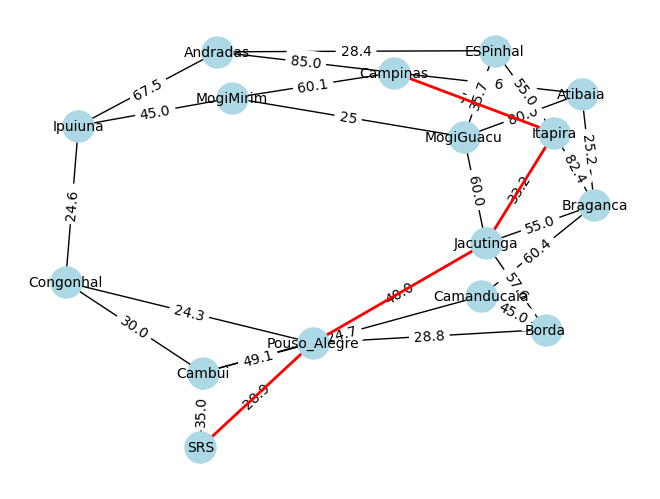

Caminho encontrado: ['SRS', 'Pouso_Alegre', 'Jacutinga', 'Itapira', 'Campinas']
Solução encontrada: True
Nós visitados: ['SRS', 'Cambui', 'Camanducaia', 'Pouso_Alegre', 'Jacutinga', 'Itapira', 'Campinas']


In [13]:
path, solucao, nos_visitados = a_star(grafo = graph, heuristicas = heuristics, inicio = "SRS", fim = "Campinas")
print(f"Caminho encontrado: {path}")
print(f"Solução encontrada: {solucao}")
print(f"Nós visitados: {[node.name for node in nos_visitados]}")

In [15]:
print(path)

['SRS', 'Pouso_Alegre', 'Jacutinga', 'Itapira', 'Campinas']
